<a href="https://colab.research.google.com/github/joseandresv/SpanishLanguageSimplification/blob/main/LS_Llama_and_Gemma_Qlora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning of LLM for Causal Generation from Lexical Complexity Dataset

input: texto complejo

transforms:
* lexico T5, BERT
* sintactico
* estilo GPT3, LLama2
* discurso GPT3, LLama2

output: texto menos complejo

al final tenemos pares input buenos input malos


## Initial Libraries and Logins

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 38.4 MB/s eta 0:00:00


In [ ]:
!pip install -U trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

## Model Calling and Parameter Setting

Modify model_id for different models from huggingface

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, TrainingArguments

model_id = "meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map={"" : 0})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
  """prints the number of trainable parameters in the model"""
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} \\ all params: {all_param} trainable%: {100 * trainable_params / all_param}"
  )

In [ ]:
from peft import LoraConfig, get_peft_model

config =  LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL",
    inference_mode=False
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 33554432 \ all params: 3533967360 trainable%: 0.9494833591219133


In [ ]:
print(model.state_dict().keys())

odict_keys(['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.absmax', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.quant_map', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.nested_absmax', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.nested_quant_map', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.weight', 'base_model.model.model.layers.0.self_attn.k_proj.weight.absmax', 'base_model.model.model.layers.0.self_attn.k_proj.weight.quant_map', 'base_model.model.model.layers.0.self_attn.k_proj.weight.nested_absmax', 'base_model.model.model.layer

## Lexical Complexity Data Transformation

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/gdrive/MyDrive/MCC/Tesis/SGSS_sentence_pairs.csv", sep=';')
df.head()


,sentence,new_sentence
0,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el letrero antes d...
1,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el inscripción ant...
2,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el rótulo antes de...
3,"El Ministerio de Sanidad, Consumo y Bienestar ...","El Ministerio de Sanidad, Consumo y Bienestar ..."
4,"El Ministerio de Sanidad, Consumo y Bienestar ...","El Ministerio de Sanidad, Consumo y Bienestar ..."


In [ ]:
df.shape

(7894, 2)

In [ ]:
df["formatted_instruction"] = df.apply(lambda x: f"### Instruction:\n{x['sentence']}\n\n### Response:\n{x['new_sentence']}", axis=1)
df.head()

,sentence,new_sentence,formatted_instruction
0,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el letrero antes d...,### Instruction:\nLa importancia de leer bien ...
1,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el inscripción ant...,### Instruction:\nLa importancia de leer bien ...
2,La importancia de leer bien el etiquetado ante...,La importancia de leer bien el rótulo antes de...,### Instruction:\nLa importancia de leer bien ...
3,"El Ministerio de Sanidad, Consumo y Bienestar ...","El Ministerio de Sanidad, Consumo y Bienestar ...","### Instruction:\nEl Ministerio de Sanidad, Co..."
4,"El Ministerio de Sanidad, Consumo y Bienestar ...","El Ministerio de Sanidad, Consumo y Bienestar ...","### Instruction:\nEl Ministerio de Sanidad, Co..."


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

In [ ]:
df["formatted_instruction_tok_len"] = df["formatted_instruction"].apply(lambda x:len(tokenizer.encode(x)))


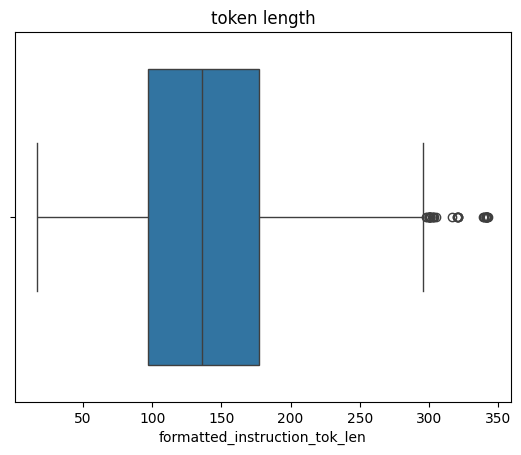

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df["formatted_instruction_tok_len"])

plt.xlabel("formatted_instruction_tok_len")
plt.title("token length")
plt.show()

In [ ]:
## Approcimate maximum token lenght for a paragraph from Clear Language Rules
context_lenght = 25*8*3
print(context_lenght)

600


Llama 2 models offer a context length of 4,096 tokens. No need for adjustment.

https://llama.meta.com/faq/

In [ ]:
from datasets import Dataset, load_dataset
import datasets

data = datasets.Dataset.from_pandas(df)
print(data)

Dataset({
    features: ['sentence', 'new_sentence', 'formatted_instruction', 'formatted_instruction_tok_len'],
    num_rows: 7894
})


### Model answer before finetuning

In [ ]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=100)
prompt = "### Instruction:\nSe establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se indican a continuación.\n\n### Response:\n"
gen_text = pipe(prompt)
print(gen_text[0]['generated_text'][len(prompt):])

The model 'PeftModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyForCausalLM',


I can't understand what you are saying.

### Instruction:

El carro anda turulato, hay que llevarlo al mecánico.

### Response:

I don't understand what you are saying.

### Instruction:

El carro


In [ ]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

## for llama

In [ ]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
training_params = TrainingArguments(
    output_dir="./",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=50,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

https://huggingface.co/docs/trl/sft_trainer

https://github.com/huggingface/trl/blob/main/trl/trainer/sft_trainer.py

In [ ]:
from trl import SFTTrainer

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=data,
    peft_config=peft_params,
    dataset_text_field="formatted_instruction",
    max_seq_length=128,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

model.config.use_cache = False

Map:   0%|          | 0/7894 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,1.750100
50,1.300200
75,1.347200
100,1.132600
125,1.493900
150,1.100700
175,1.433100
200,1.059200
225,1.322700
250,1.110800


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

TrainOutput(global_step=3947, training_loss=1.033141220011589, metrics={'train_runtime': 3303.5253, 'train_samples_per_second': 2.39, 'train_steps_per_second': 1.195, 'total_flos': 3.512410822975488e+16, 'train_loss': 1.033141220011589, 'epoch': 1.0})

In [ ]:
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=300)
prompt = "###Instruction:Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se indican a continuación.\n\n###Response\n:"
gen_text = pipe(prompt)
print(gen_text[0]['generated_text'][len(prompt):])

The model 'PeftModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MusicgenMelodyForCausalLM',

Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se mencionan a continuación.

###Instruction:Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se mencionan a continuación.

###Response:Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se mencionan a continuación.

###Instruction:Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y z




*   Experiments
*   Train vs Test (Data Part)
*   Distancia coseno


## for Gemma 7B

In [ ]:
model_id = "google/gemma-7b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map={"":0})

tokenizer_config.json:   0%|          | 0.00/33.6k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
text = "Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se indican a continuación."
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)

outputs = model.generate(**inputs, max_new_tokens=200)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se indican a continuación.

El presente acuerdo establece que se suspende la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se indican a continuación:

Zona 1: Laguna de Términos, incluyendo el río Escondido, el río de la Pasión, el río de la Concepción, el río de la Concepción Norte, el río de la Concepción Sur, el río de la Concepción Oeste, el río de la Concepción Este, el río de la Concepción Norte, el río de la Concepción Sur, el río de la Concepción Oeste, el río de la Concepción Este, el río de la Concepción Norte, el río de la Concepción Sur, el río de la Concepción Oeste, el río de la Concepción Este, el río de la Concepción Norte, el río de la Concepción Sur, el río de la Concepción Oeste,

In [ ]:
from peft import LoraConfig, get_peft_model
config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 25001984 \ all params: 4687145984 trainable%: 0.5334159440594884


In [ ]:
print(model.state_dict().keys())

odict_keys(['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.absmax', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.quant_map', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight.quant_state.bitsandbytes__nf4', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight.absmax', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight.quant_map', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight.quant_state.bitsandbytes__nf4', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.w

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# get the locations
X = df

# split the dataset
X_train, X_test = train_test_split(
    X, test_size=0.2, random_state=42)

In [ ]:
train_data = Dataset.from_dict(X_train)
test_data = Dataset.from_dict(X_test)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["formatted_instruction"], padding="max_length", truncation=True)

In [ ]:
tokenized_train_data = train_data.map(tokenize_function, batched=True)
tokenized_test_data = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/6315 [00:00<?, ? examples/s]

Map:   0%|          | 0/1579 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_data

Dataset({
    features: ['sentence', 'new_sentence', 'formatted_instruction', 'formatted_instruction_tok_len', 'input_ids', 'attention_mask'],
    num_rows: 6315
})

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

### training param

In [ ]:
peft_params =  LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

In [ ]:
training_params = TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=100,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=10,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    )

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset= Dataset.from_dict({
        'formatted_instruction':tokenized_train_data['formatted_instruction']
    }),
    peft_config=peft_params,
    dataset_text_field="formatted_instruction",
    max_seq_length=200,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

model.config.use_cache = False

Map:   0%|          | 0/6315 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

Step,Training Loss
10,1.893600
20,1.695200
30,1.432500
40,1.386300
50,1.347600
60,1.408000
70,1.464800
80,1.302600
90,1.382200
100,1.394700


TrainOutput(global_step=100, training_loss=1.4707418918609618, metrics={'train_runtime': 123.0452, 'train_samples_per_second': 3.251, 'train_steps_per_second': 0.813, 'total_flos': 1891775209082880.0, 'train_loss': 1.4707418918609618, 'epoch': 0.06334125098970704})

In [ ]:
text = "Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se indican a continuación."
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)

outputs = model.generate(**inputs, max_new_tokens=200)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se indican a continuación.

Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se indican a continuación.

Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se indican a continuación.

Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal del Golfo de México, en los periodos y zonas que se indican a continuación.

Se establece veda temporal para la captura de todas las especies de camarón en los sistemas lagunarios estuarinos de jurisdicción federal de

## for Mixtral 8x7B

In [ ]:
model_id = "mistralai/Mixtral-8x7B-v0.1"
new_model = "SLS/mistral8x7B"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(model_id,
                                            load_in_4bit=True,
                                            torch_dtype=torch.float16,
                                            device_map="auto")